In [5]:
from google.colab import drive
from pathlib import Path
import os

drive.mount("/content/drive")

PROJECT = Path("/content/drive/MyDrive/gb-flex-desk")  # change name if you want
PROJECT.mkdir(parents=True, exist_ok=True)
os.chdir(PROJECT)

Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)

print("cwd:", Path.cwd())
print("prices exists?", Path("data/processed/prices.parquet").exists())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cwd: /content/drive/MyDrive/gb-flex-desk
prices exists? True


In [6]:
import pandas as pd

df = pd.read_parquet("data/processed/preds.parquet").sort_values("ts").reset_index(drop=True)
print("rows:", len(df))
print("columns:", list(df.columns))
print("time range:", df["ts"].min(), "to", df["ts"].max())
df.head()


rows: 17519
columns: ['ts', 'sbp', 'ssp', 'pred']
time range: 2024-12-07 00:00:00 to 2025-12-06 23:00:00


,ts,sbp,ssp,pred
0,2024-12-07 00:00:00,24.089521,24.089521,35.679037
1,2024-12-07 00:30:00,30.896732,30.896732,33.603436
2,2024-12-07 01:00:00,30.410000,30.410000,35.905037
3,2024-12-07 01:30:00,33.769878,33.769878,37.630586
4,2024-12-07 02:00:00,44.910000,44.910000,36.382431


In [8]:
import pandas as pd

# Load model predictions (ts, sbp, ssp, pred)
df = pd.read_parquet("data/processed/preds.parquet").sort_values("ts").reset_index(drop=True)

# Rolling thresholds: what counts as "low" and "high" price
roll = df["sbp"].rolling(48*7, min_periods=48*2)  # 1 week window (warmup allowed)
df["q20"] = roll.quantile(0.2)
df["q80"] = roll.quantile(0.8)

# Desired action from the signal (what we would LIKE to do)
# +1 = discharge, -1 = charge, 0 = hold
df["desired_action"] = 0
df.loc[df["pred"] > df["q80"], "desired_action"] = 1
df.loc[df["pred"] < df["q20"], "desired_action"] = -1

df[["ts", "sbp", "pred", "q20", "q80", "desired_action"]].tail()

,ts,sbp,pred,q20,q80,desired_action
17514,2025-12-06 21:00:00,59.05,76.303711,59.05,94.7,0
17515,2025-12-06 21:30:00,60.80,73.235662,59.05,94.7,0
17516,2025-12-06 22:00:00,100.00,73.009520,59.05,94.9,0
17517,2025-12-06 22:30:00,50.00,81.365551,59.05,94.9,0
17518,2025-12-06 23:00:00,50.00,68.570686,59.05,94.7,0


Total PnL (£): 12526.36
Number of charge periods: 354
Number of discharge periods: 279
Final SOC (MWh): 2.0 out of 2.0


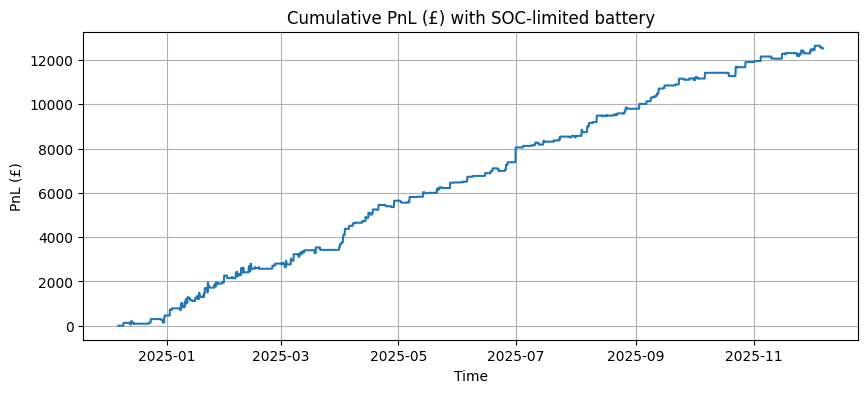

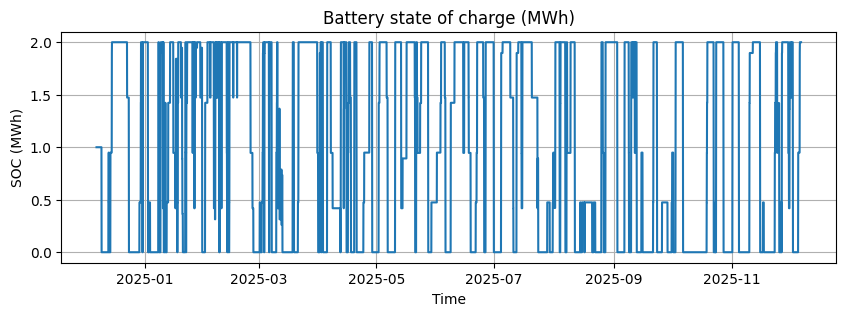

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load predictions created in Notebook 4 ---
# This file should contain: ts, sbp, ssp, pred
df = pd.read_parquet("data/processed/preds.parquet").sort_values("ts").reset_index(drop=True)

# --- 1) Create the trading rule thresholds ---
# We use rolling quantiles of *recent* SBP to decide what counts as "low" or "high".
# This avoids hardcoding an absolute price level.
window = 48 * 7  # 1 week of half-hour settlement periods
roll = df["sbp"].rolling(window=window, min_periods=48*2)  # allow a warmup period

df["q20"] = roll.quantile(0.20)  # low price region
df["q80"] = roll.quantile(0.80)  # high price region

# Desired action from the model:
# +1 means "discharge battery" (sell energy)
# -1 means "charge battery" (buy energy)
#  0 means "do nothing"
df["desired_action"] = 0
df.loc[df["pred"] > df["q80"], "desired_action"] = 1
df.loc[df["pred"] < df["q20"], "desired_action"] = -1

# --- 2) Battery assumptions (change these to match the story you want to tell) ---
P_MW = 1.0            # max charge or discharge power
E_MWH = 2.0           # energy capacity (2-hour battery at 1 MW)
RTE = 0.90            # round-trip efficiency (overall)
eta_c = np.sqrt(RTE)  # charge efficiency (split RTE evenly)
eta_d = np.sqrt(RTE)  # discharge efficiency

SP_HOURS = 0.5        # settlement period length (30 minutes)
E_PER_SP = P_MW * SP_HOURS  # MWh moved if running at full power for one period

# --- 3) Simulate state of charge (SOC) through time ---
soc = 0.5 * E_MWH     # start half full, in MWh
soc_series = []
pnl_series = []
action_series = []

for i, row in df.iterrows():
    desired = int(row["desired_action"])

    # Default: do nothing
    energy_in = 0.0   # MWh bought from grid this period
    energy_out = 0.0  # MWh sold to grid this period
    action = 0

    # If we want to DISCHARGE (sell)...
    if desired == 1:
        # At full power we'd export E_PER_SP MWh, but we may be limited by SOC.
        # Because discharge is not 100% efficient, exporting energy_out requires
        # energy_out / eta_d to be removed from the battery.
        max_export = soc * eta_d
        energy_out = min(E_PER_SP, max_export)

        # Update SOC after discharge
        soc = soc - (energy_out / eta_d)
        action = 1 if energy_out > 0 else 0

    # If we want to CHARGE (buy)...
    elif desired == -1:
        # At full power we'd import E_PER_SP MWh, but we may be limited by remaining capacity.
        # Because charging is not 100% efficient, importing energy_in only stores energy_in * eta_c.
        max_import = (E_MWH - soc) / eta_c
        energy_in = min(E_PER_SP, max_import)

        # Update SOC after charge
        soc = soc + (energy_in * eta_c)
        action = -1 if energy_in > 0 else 0

    # Profit for this period in £:
    # buy at SSP when charging, sell at SBP when discharging
    pnl = (energy_out * row["sbp"]) - (energy_in * row["ssp"])

    soc_series.append(soc)
    pnl_series.append(pnl)
    action_series.append(action)

df["soc_mwh"] = soc_series
df["pnl_gbp"] = pnl_series
df["action"] = action_series
df["cum_pnl_gbp"] = df["pnl_gbp"].cumsum()

# --- 4) Quick checks ---
print("Total PnL (£):", round(df["pnl_gbp"].sum(), 2))
print("Number of charge periods:", int((df["action"] == -1).sum()))
print("Number of discharge periods:", int((df["action"] == 1).sum()))
print("Final SOC (MWh):", round(df["soc_mwh"].iloc[-1], 3), "out of", E_MWH)

# --- 5) Plot cumulative PnL and SOC ---
plt.figure(figsize=(10,4))
plt.plot(df["ts"], df["cum_pnl_gbp"])
plt.title("Cumulative PnL (£) with SOC-limited battery")
plt.xlabel("Time")
plt.ylabel("PnL (£)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(df["ts"], df["soc_mwh"])
plt.title("Battery state of charge (MWh)")
plt.xlabel("Time")
plt.ylabel("SOC (MWh)")
plt.grid(True)
plt.show()
